# PEAK FINDING

### READING DATA

In [3]:
cd ../CRUX_Data/

/home/aad157/CRUX_Data


In [23]:
import pandas as pd

In [27]:
data.columns

Index(['Angle', ' TimePerStep', ' Intensity'], dtype='object')

# MODEL 1

In [6]:
import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize, signal

from lmfit import models

In [9]:
def generate_model(spec):
    composite_model = None
    params = None
    x = spec['x']
    y = spec['y']
    x_min = np.min(x)
    x_max = np.max(x)x
    x_range = x_max - x_min
    y_max = np.max(y)
    for i, basis_func in enumerate(spec['model']):
        prefix = f'm{i}_'
        model = getattr(models, basis_func['type'])(prefix=prefix)
        if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']: # for now VoigtModel has gamma constrained to sigma
            model.set_param_hint('sigma', min=1e-6, max=x_range)
            model.set_param_hint('center', min=x_min, max=x_max)
            model.set_param_hint('height', min=1e-6, max=1.1*y_max)
            model.set_param_hint('amplitude', min=1e-6)
            # default guess is horrible!! do not use guess()
            default_params = {
                prefix+'center': x_min + x_range * random.random(),
                prefix+'height': y_max * random.random(),
                prefix+'sigma': x_range * random.random()
            }
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
        if 'help' in basis_func:  # allow override of settings in parameter
            for param, options in basis_func['help'].items():
                model.set_param_hint(param, **options)
        model_params = model.make_params(**default_params, **basis_func.get('params', {}))
        if params is None:
            params = model_params
        else:
            params.update(model_params)
        if composite_model is None:
            composite_model = model
        else:
            composite_model = composite_model + model
    return composite_model, params

In [7]:
def update_spec_from_peaks(spec, model_indicies, peak_widths=(10, 25), **kwargs):
    x = spec['x']
    y = spec['y']
    x_range = np.max(x) - np.min(x)
    peak_indicies = signal.find_peaks_cwt(y, peak_widths)
    np.random.shuffle(peak_indicies)
    for peak_indicie, model_indicie in zip(peak_indicies.tolist(), model_indicies):
        model = spec['model'][model_indicie]
        if model['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']:
            params = {
                'height': y[peak_indicie],
                'sigma': x_range / len(x) * np.min(peak_widths),
                'center': x[peak_indicie]
            }
            if 'params' in model:
                model.update(params)
            else:
                model['params'] = params
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
    return peak_indicies

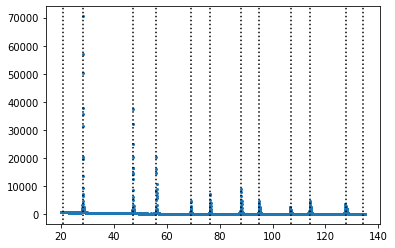

In [11]:
spec = {
    'x': data['Angle'],
    'y': data['Intensity'],
    'model': [
        {'type': 'VoigtModel',
        #'params': {'center': 29, 'height': 13.08, 'sigma': 0.1},
        },
        {'type': 'VoigtModel', 
        #'params': {'center': 33, 'height': 13.08, 'sigma': 0.1},
        },
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'GaussianModel',
        #'params': {'center': 31, 'sigma': 0.1},
        },
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
    ]
}

peaks_found = update_spec_from_peaks(spec, [0,1,2,3,4,5,6], peak_widths=(30,))
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
for i in peaks_found:
    ax.axvline(x=spec['x'][i], c='black', linestyle='dotted')

# END

# MODEL 2

In [12]:
import numpy
import peakutils
from peakutils.plot import plot as pplot
from matplotlib import pyplot
%matplotlib inline


Text(0.5, 1.0, 'First estimate')

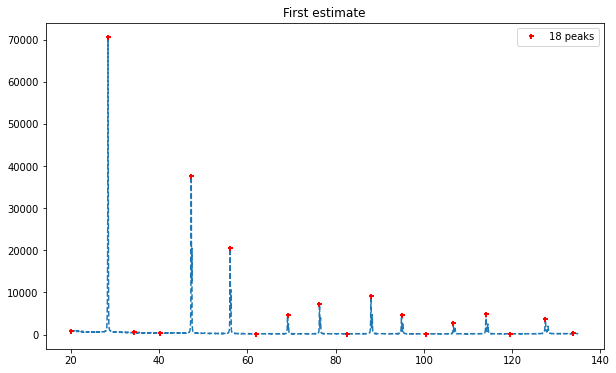

In [14]:
indexes = peakutils.indexes(data['Intensity'], thres=0.02/max(data['Intensity']), min_dist=200)
x = data['Angle']
y = data['Intensity']
pyplot.figure(figsize=(10,6))
pplot(x, y, indexes)
pyplot.title('First estimate')

## MODEL 2 refine results

In [15]:
#peakutils.interpolate(range(10, len(cb)), cb, ind=indexes)
peaks_x = peakutils.interpolate(x.values, y.values, ind=indexes)
print(peaks_x)

[  4.          28.42457915  34.2603138   40.29090908  47.29898214
  56.12551698  61.98478994  69.1494841   76.38612987  82.57195772
  88.00792878  94.93188956 100.44546777 106.69144043 114.07844754
 119.46206578 127.5381793  133.75901094]


/home/aad157/.local/lib/python3.8/site-packages/peakutils/peak.py:246: UserWarning: At least 3 points required for Gaussian fitting
  warnings.warn(str(e))


# END

# MODEL 3

In [22]:
def peak_finding(data,window_size):
    data_extended = np.concatenate([np.zeros(window_size),data,np.zeros(window_size)])
    max_list = []
        
    for i,value in enumerate(data_extended):
        if (i >= window_size) and (i < len(data_extended)-window_size):
            try:
                max_left = data_extended[(i-window_size):i+1].max()
                max_right = data_extended[i:(i+window_size)+1].max()
                chek_value = data_extended[i] - ((max_left+max_right)/2)
            except ValueError:
                 pass
                
            if (chek_value >=0):
                max_list.append((i-window_size,data[(i-window_size)]))
    return max_list

In [18]:
df = data[['Angle','Intensity']]
peaks_list = peak_finding(df['Intensity'],200)
x_peaks = [ x for x,y in peaks_list]
y_peaks = [ y for x,y in peaks_list ]

In [19]:
x_peaks_n = data['Angle'][x_peaks]

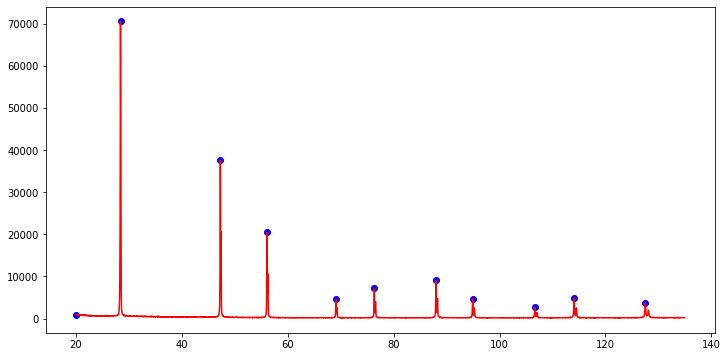

In [20]:
fig = plt.figure(figsize=(12,6))
#ax = fig.add_axes([0.1, 0.3, 0.4, 0.4])
plt.plot(df['Angle'],df['Intensity'],color='red');
plt.scatter(x_peaks_n,y_peaks,color='blue');

# END

# TESTING (IGNORE)

In [1]:
import pandas as pd

In [2]:
pwd

'/home/aad157/CRUX'

In [6]:
df = pd.read_csv('Processing Data (Responses) - Form Responses 1.csv')

In [7]:
tech = df['Materials Processing Technique']
para = df['Important Parameters related to the processing technique']

In [8]:
para = para.apply(lambda x:x.lower())

In [9]:
final_dict = dict(zip(tech, para))

In [5]:
import json

In [6]:
dict_tech = json.dumps(final_dict)

NameError: name 'final_dict' is not defined

In [64]:
data = pd.read_csv('MnO2_Unmilled_Air_25to1100øC_182.csv')

In [4]:
data = pd.read_csv('A Basic Calibration BBHD Program-3_1.csv')

In [5]:
data = data.rename(columns={' Intensity': 'Intensity'})

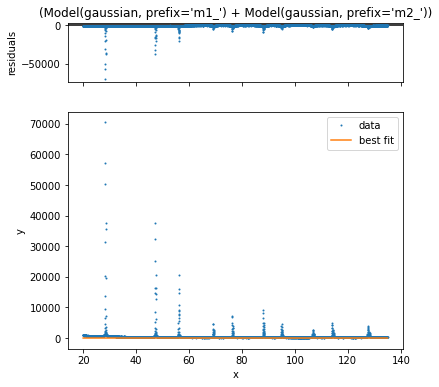

In [13]:
model_1 = models.GaussianModel(prefix='m1_')
model_2 = models.GaussianModel(prefix='m2_')
model = model_1 + model_2

params_1 = model_1.make_params(center=1, sigma=1)
params_2 = model_2.make_params(center=-1, sigma=1)
params = params_1.update(params_2)

output = model.fit(data['Intensity'],params ,x =  data['Angle'])
fig = output.plot(data_kws={'markersize': 1})

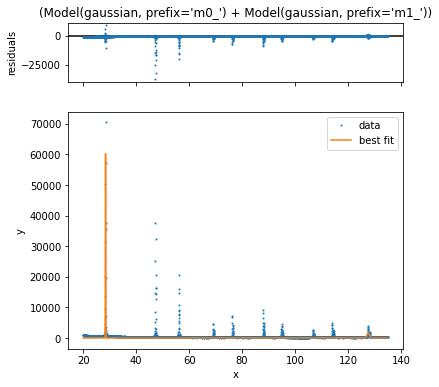

In [10]:
spec = {
    'x': data['Angle'],
    'y': data['Intensity'],
    'model': [
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'}
    ]
}

model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig = output.plot(data_kws={'markersize': 1})

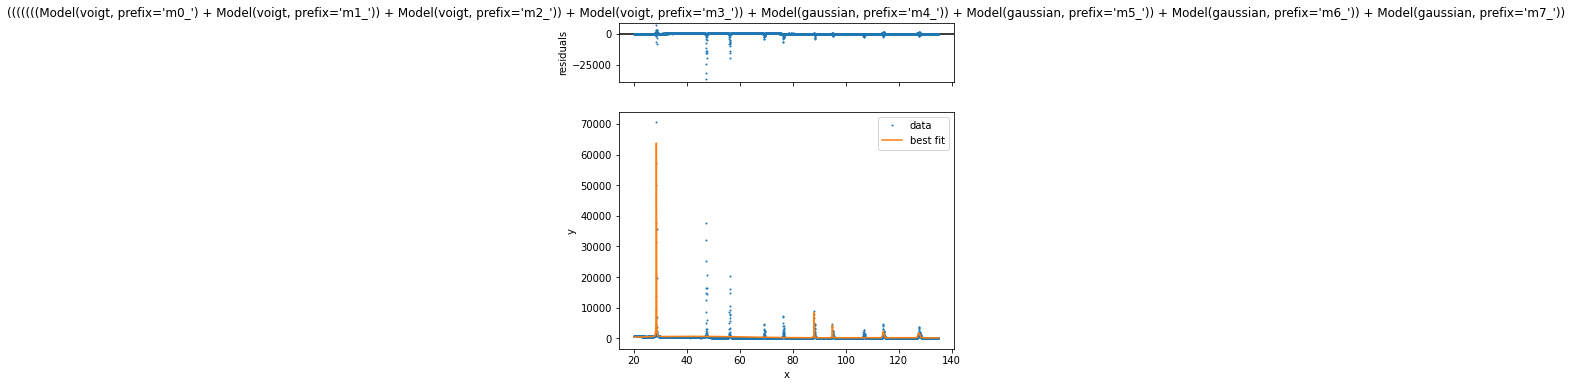

In [14]:
model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig = output.plot(data_kws={'markersize':  1})

AttributeError: 'Series' object has no attribute 'real'

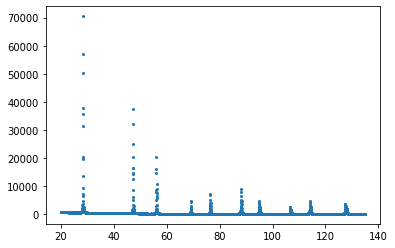

In [15]:
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])
print(len(spec['model']))o
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])

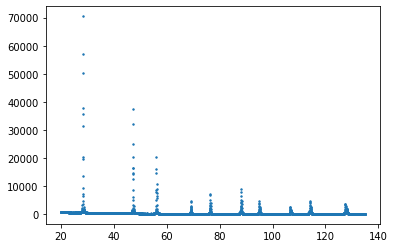

In [16]:

fig, ax = plt.subplots()
ax.scatter(data['Angle'], data['Intensity'], s=2)
#plot_to_blog(fig, 'xrd-fitting-gaussian-noise.png')

In [101]:
def print_best_values(spec, output):
    model_params = {
        'GaussianModel':   ['amplitude', 'sigma'],
        'LorentzianModel': ['amplitude', 'sigma'],
        'VoigtModel':      ['amplitude', 'sigma', 'gamma']
    }
    best_values = output.best_values
    print('center    model   amplitude     sigma      gamma')
    for i, model in enumerate(spec['model']):
        prefix = f'm{i}_'
        values = ', '.join(f'{best_values[prefix+param]:8.3f}' for param in model_params[model["type"]])
        print(f'[{best_values[prefix+"center"]:3.3f}] {model["type"]:16}: {values}')

In [102]:
print_best_values(spec, output)

center    model   amplitude     sigma      gamma
[28.424] VoigtModel      : 10770.069,    0.035,    0.035
[35.221] VoigtModel      :    0.764,    0.018,    0.018
[76.353] VoigtModel      :  964.956,    0.029,    0.029
[47.289] VoigtModel      : 6301.988,    0.044,    0.044
[24.754] GaussianModel   :  178.426,    0.004
[80.479] GaussianModel   :    0.817,    0.006
[88.008] GaussianModel   : 1044.964,    0.052
[20.018] GaussianModel   : 110371.944,   98.306


Text(0.5, 1.0, 'Data with baseline')

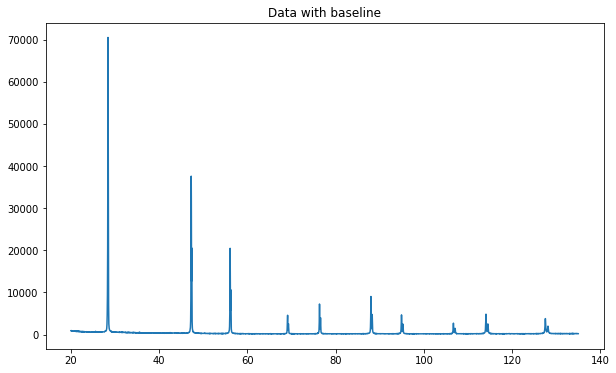

In [32]:
y2 = y + numpy.polyval([0.002,-0.08,5], x)
pyplot.figure(figsize=(10,6))
pyplot.plot(x, y2)
pyplot.title("Data with baseline")

Text(0.5, 1.0, 'Data with baseline removed')

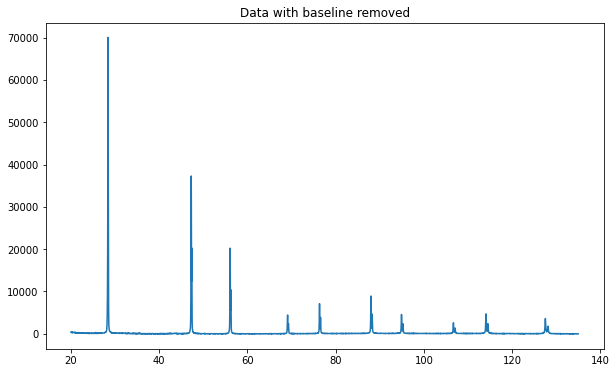

In [34]:
base = peakutils.baseline(y2, 2)
pyplot.figure(figsize=(10,6))
pyplot.plot(x, y2-base)
pyplot.title("Data with baseline removed")

In [121]:
!pip install vector

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 156 kB 4.6 MB/s            
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [138]:
import numpy as np

vector = [
    0, 6, 25, 20, 15, 8, 15, 6, 0, 6, 0, -5, -15, -3, 4, 10, 8, 13, 8, 10, 3,
    1, 20, 7, 3, 0
]

# This is an extract from Laurent Garnier Cryspy Bacon track.
# https://www.youtube.com/watch?v=6SFD7fz8fWc
# Converted from MP3 to WAV, then imported as a Numpy array.
# No Copyright infringement intended. For educational purpose only.
cb = np.array([-0.010406, -0.0080872, -0.0066528, -0.0074158, -0.0072937, -0.0063782, -0.005249, -0.0038147, -0.0021973, -0.0011902, -0.0014954, -0.00036621, 0.00030518, -0.00027466, -0.00073242, 0.0014648, 0.0025635, 0.0019531, 0.0033875, 0.0037842, 0.0047913, 0.0059509, 0.0049133, 0.0059814, 0.007019, 0.0062256, 0.0069885, 0.0074463, 0.007782, 0.0086975, 0.0089722, 0.0097656, 0.0083313, 0.0087585, 0.01001, 0.010345, 0.011139, 0.010345, 0.01123, 0.012482, 0.012329, 0.012573, 0.011505, 0.010773, 0.011017, 0.011658, 0.011353, 0.010498, 0.010803, 0.010773, 0.011932, 0.013184, 0.013428, 0.012665, 0.012451, 0.011993, 0.010559, 0.01004, 0.0097351, 0.0098267, 0.0099792, 0.0098267, 0.0092468, 0.0089111, 0.0088501, 0.0090027, 0.0088196, 0.0079346, 0.0068054, 0.006897, 0.0077209, 0.0073853, 0.0069275, 0.0046692, 0.0021362, 0.0013733, 0.00021362, -0.0024414, -0.0045776, -0.0067444, -0.0083313, -0.0088806, -0.011688, -0.012207, -0.012756, -0.01532, -0.014984, -0.017212, -0.020844, -0.022247, -0.022614, -0.023773, -0.02356, -0.024323, -0.025177, -0.024353, -0.02594, -0.026794, -0.02829, -0.029236, -0.029388, -0.030304, -0.030914, -0.032593, -0.032867, -0.03363, -0.032867, -0.03009, -0.032501, -0.035034, -0.035339, -0.035492, -0.035614, -0.037018, -0.037476, -0.039001, -0.039886, -0.038818, -0.039215, -0.039917, -0.041107, -0.041931, -0.042206, -0.042419, -0.043762, -0.043427, -0.041992, -0.043915, -0.043854, -0.045929, -0.047607, -0.046265, -0.045807, -0.045135, -0.045715, -0.045898, -0.04538, -0.043579, -0.043518, -0.04425, -0.043823, -0.044617, -0.045227, -0.044159, -0.042877, -0.044708, -0.043732, -0.043152, -0.043182, -0.041473, -0.041718, -0.04303, -0.043121, -0.042236, -0.043335, -0.043121, -0.041321, -0.042328, -0.043274, -0.040955, -0.040375, -0.041687, -0.039063, -0.038177, -0.039215, -0.037354, -0.037079, -0.036835, -0.035797, -0.035492, -0.034241, -0.032776, -0.033295, -0.033112, -0.03186, -0.031891, -0.032074, -0.030182, -0.030365, -0.03125, -0.030334, -0.029877, -0.028687, -0.028381, -0.027588, -0.028503, -0.029114, -0.02832, -0.025635, -0.025085, -0.024231, -0.022339, -0.022858, -0.021942, -0.020447, -0.020386, -0.02066, -0.018402, -0.018372, -0.018219, -0.017731, -0.017395, -0.016602, -0.016296, -0.013702, -0.011688, -0.013153, -0.013123, -0.012512, -0.012787, -0.012634, -0.011993, -0.011963, -0.01062, -0.011017, -0.010803, -0.0097351, -0.0089722, -0.0089111, -0.0083923, -0.0074463, -0.0071411, -0.0071716, -0.0061951, -0.0055237, -0.0044556, -0.0046387, -0.0054016, -0.0055847, -0.0041809, -0.0029297, -0.0036011, -0.0030823, -0.0018311, -0.0011902, -6.1035e-05, -0.00030518, -0.0015564, -0.00094604, -0.0013428, -0.0018921, 0.00061035, 0.0024414, 0.0014648, 0.0015564, 0.0018616, 0.0016479, 0.0013428, 0.0015564, 0.0027466, 0.0022583, 0.0012817, 0.0015259, 0.0019226, 0.0027161, 0.0020752, 0.0013123, 0.0024109, 0.0028076, 0.0030212, 0.0030823, 0.0047607, 0.0055847, 0.0053101, 0.0045776, 0.0049438, 0.004425, 0.0010376, 0.0007019, 0.0029297, 0.0048828, 0.0036316, 0.0038147, 0.0045776, 0.0040283, 0.0048828, 0.0049133, 0.0067444, 0.0082092, 0.0082703, 0.010193, 0.010712, 0.012054, 0.013947, 0.015137, 0.017639, 0.019623, 0.02124, 0.023193, 0.026093, 0.028076, 0.028931, 0.030914, 0.031769, 0.032043, 0.032654, 0.033417, 0.034149, 0.034393, 0.034607, 0.034058, 0.035187, 0.035828, 0.037506, 0.039093, 0.040253, 0.042145, 0.043671, 0.045227, 0.045959, 0.047882, 0.04892, 0.049591, 0.052002, 0.055756, 0.058777, 0.059937, 0.061096, 0.062927, 0.065491, 0.066772, 0.068268, 0.068604, 0.068634, 0.07016, 0.071167, 0.070251, 0.069885, 0.071136, 0.07135, 0.072266, 0.073151, 0.073334, 0.073425, 0.071747, 0.070984, 0.07193, 0.071533, 0.071167, 0.072021, 0.071503, 0.068817, 0.068359, 0.069733, 0.068085, 0.066589, 0.066071, 0.066956, 0.066101, 0.063812, 0.063385, 0.062012, 0.060638, 0.058289, 0.055267, 0.054596, 0.053864, 0.052582, 0.051025, 0.05014, 0.04953, 0.047638, 0.045624, 0.044189, 0.042297, 0.039856, 0.038788, 0.038391, 0.036591, 0.034302, 0.033295, 0.031647, 0.029755, 0.028168, 0.02475, 0.022064, 0.020294, 0.019135, 0.016174, 0.012665, 0.011322, 0.0095215, 0.0067139, 0.0045471, 0.0029907, 0.00082397, -0.0013428, -0.0024109, -0.0053101, -0.0079956, -0.0096436, -0.01178, -0.013489, -0.015472, -0.018616, -0.020874, -0.023468, -0.02533, -0.027496, -0.029907, -0.032318, -0.034546, -0.036865, -0.039093, -0.040558, -0.042206, -0.04541, -0.047058, -0.048401, -0.051819, -0.054321, -0.055756, -0.057037, -0.059296, -0.061798, -0.063446, -0.065002, -0.067261, -0.069366, -0.070251, -0.071686, -0.073792, -0.075745, -0.076263, -0.078278, -0.080475, -0.081329, -0.081665, -0.083313, -0.08548, -0.086395, -0.088562, -0.090332, -0.091766, -0.092163, -0.093475, -0.095306, -0.096436, -0.09726, -0.096588, -0.097717, -0.098785, -0.099579, -0.10199, -0.10263, -0.10388, -0.10428, -0.10468, -0.1051, -0.10605, -0.10608, -0.10651, -0.10818, -0.10764, -0.10779, -0.10791, -0.10818, -0.10815, -0.10928, -0.10934, -0.10931, -0.11139, -0.10992, -0.10907, -0.11057, -0.10889, -0.11023, -0.11087, -0.10855, -0.1091, -0.1098, -0.10883, -0.10818, -0.10812, -0.10806, -0.10699, -0.10785, -0.10791, -0.10602, -0.10562, -0.10541, -0.10449, -0.10373, -0.10345, -0.10266, -0.10187, -0.10178, -0.10056, -0.10068, -0.099396, -0.098297, -0.097961, -0.096375, -0.096649, -0.095795, -0.094055, -0.094025, -0.092468, -0.092682, -0.091919, -0.08963, -0.088043, -0.086761, -0.08609, -0.084045, -0.082764, -0.082001, -0.081207, -0.081116, -0.078522, -0.077118, -0.077515, -0.075958, -0.074158, -0.07254, -0.070892, -0.070923, -0.069794, -0.067902, -0.067108, -0.066589, -0.066132, -0.066406, -0.066895, -0.065613, -0.065613, -0.065521, -0.065613, -0.06604, -0.065338, -0.064392, -0.063324, -0.062714, -0.063263, -0.062653, -0.061432, -0.060486, -0.059357, -0.057953, -0.056854, -0.056274, -0.056061, -0.055542, -0.054352, -0.05249, -0.051025, -0.049652, -0.048828, -0.047974, -0.046722, -0.046234, -0.044769, -0.043427, -0.041962, -0.042023, -0.040619, -0.037781, -0.037262, -0.036163, -0.03476, -0.03363, -0.032104, -0.031281, -0.0289, -0.02652, -0.026123, -0.024719, -0.023132, -0.023041, -0.021667, -0.018921, -0.018738, -0.01767, -0.016205, -0.014496, -0.012421, -0.011261, -0.0098267, -0.0087585, -0.0072937, -0.005249, -0.004425, -0.0028992, -0.00039673, 0.00085449, 0.0021667, 0.0040588, 0.003479, 0.006012, 0.0083923, 0.0086975, 0.010529, 0.011627, 0.013214, 0.015778, 0.017151, 0.018219, 0.019562, 0.02066, 0.0224, 0.023621, 0.024994, 0.027679, 0.028015, 0.030762, 0.031921, 0.032104, 0.034943, 0.036652, 0.037323, 0.038879, 0.040985, 0.042236, 0.042603, 0.044556, 0.046295, 0.047852, 0.048981, 0.049683, 0.051575, 0.053467, 0.054291, 0.055908, 0.05777, 0.058105, 0.060059, 0.062042, 0.062225, 0.064117, 0.065247, 0.064636, 0.067505, 0.069641, 0.069794, 0.071808, 0.073303, 0.073486, 0.074219, 0.075684, 0.077454, 0.078247, 0.079102, 0.080688, 0.081268, 0.08197, 0.083191, 0.084137, 0.082764, 0.084656, 0.086945, 0.087555, 0.08905, 0.088715, 0.089325, 0.092133, 0.092682, 0.094177, 0.093689, 0.093903, 0.096863, 0.098083, 0.09848, 0.097839, 0.098755, 0.099487, 0.098999, 0.10013, 0.10031, 0.10095, 0.10153, 0.10245, 0.10449, 0.10391, 0.10379, 0.10464, 0.10391, 0.1051, 0.10434, 0.10483, 0.10681, 0.10614, 0.10635, 0.10785, 0.10611, 0.10648, 0.10797, 0.10745, 0.10773, 0.10849, 0.10742, 0.10825, 0.10892, 0.10809, 0.11011, 0.10889, 0.10843, 0.10977, 0.10785, 0.10971, 0.1091, 0.10828, 0.10883, 0.10739, 0.10925, 0.10855, 0.108, 0.10849, 0.1073, 0.10727, 0.108, 0.10825, 0.10675, 0.10645, 0.10611, 0.10611, 0.10645, 0.1069, 0.10535, 0.10513, 0.10629, 0.10498, 0.10361, 0.10431, 0.10345, 0.10391, 0.1037, 0.10138, 0.10034, 0.10114, 0.10034, 0.099731, 0.099915, 0.10138, 0.10388, 0.10309, 0.10327, 0.10562, 0.10501, 0.10538, 0.10504, 0.10327, 0.10193, 0.10101, 0.10019, 0.098541, 0.097015, 0.096741, 0.097412, 0.095856, 0.093719, 0.092987, 0.093536, 0.092651, 0.090973, 0.090607, 0.088867, 0.087738, 0.087189, 0.086609, 0.085205, 0.084412, 0.082336, 0.082306, 0.081421, 0.079926, 0.080231, 0.078827, 0.076904, 0.076385, 0.075806, 0.073822, 0.074188, 0.072205, 0.071106, 0.070923, 0.068695, 0.06839, 0.066437, 0.065704, 0.064209, 0.060883, 0.057861, 0.054565, 0.052673, 0.05014, 0.048065, 0.046448, 0.043793, 0.041382, 0.039154, 0.036987, 0.034912, 0.033539, 0.030121, 0.026031, 0.022949, 0.018707, 0.015442, 0.01355, 0.0094299, 0.0065918, 0.0042419, 0.00082397, -0.00054932, -0.0040283, -0.0057373, -0.0078735, -0.010895, -0.01181, -0.01358, -0.01593, -0.018799, -0.020905, -0.021576, -0.022278, -0.022766, -0.024933, -0.027313, -0.027557, -0.03006, -0.030945, -0.032074, -0.034271, -0.034851, -0.036255, -0.038696, -0.03949, -0.039856, -0.041443, -0.041809, -0.042877, -0.043579, -0.043427, -0.045593, -0.04538, -0.045013, -0.047852, -0.048004, -0.049225, -0.050293, -0.048218, -0.048706, -0.049194, -0.049988, -0.052368, -0.050995, -0.051819, -0.051971, -0.050812, -0.051971, -0.052185, -0.051575, -0.050842, -0.052429, -0.051392, -0.050537, -0.051056, -0.050568, -0.050964, -0.050446, -0.049164, -0.049072, -0.049438, -0.048798, -0.048309, -0.048157, -0.048462, -0.046509, -0.046753, -0.046265, -0.04422, -0.045135, -0.043213, -0.04248, -0.043549, -0.041443, -0.039093, -0.039856, -0.039276, -0.037659, -0.036469, -0.034607, -0.035431, -0.034485, -0.032928, -0.032867, -0.031158, -0.030212, -0.029327, -0.027893, -0.0271, -0.025269, -0.024048, -0.024597, -0.022736, -0.021393, -0.020844, -0.019775, -0.018982, -0.017029, -0.016663, -0.015961, -0.015289, -0.014526, -0.012146, -0.011658, -0.011108, -0.0084534, -0.0082092, -0.0079651, -0.006012, -0.0049133, -0.0043945, -0.0046692, -0.00354, -0.0016479, 0.00033569, 0.0018921, 0.0016479, 0.002594, 0.0039978, 0.0029602, 0.0047913, 0.0067444, 0.0061035, 0.0078125, 0.0082703, 0.0077515, 0.01001, 0.010162, 0.011658, 0.012482, 0.01236, 0.013336, 0.014374, 0.015137, 0.015442, 0.015564, 0.0177, 0.018494, 0.017914, 0.017242, 0.01828, 0.019043, 0.019043, 0.020203, 0.020477, 0.020905, 0.020599, 0.021057, 0.022583, 0.0224, 0.02298, 0.024017, 0.023743, 0.023376, 0.023071, 0.024231, 0.023987, 0.023895, 0.02356, 0.024811, 0.024658, 0.023163, 0.024567, 0.024872, 0.022797, 0.022949, 0.024445, 0.023041, 0.02121, 0.021393, 0.019531, 0.016388, 0.016663, 0.015137, 0.012268, 0.011414, 0.0098572, 0.0092468, 0.0080566, 0.0061646, 0.0057373, 0.0042725, 0.0044556, 0.0042419, 0.0021057, 0.0014954, 0.0010681, 0.0005188, -9.1553e-05, -0.00048828, -0.0016785, -0.0027466, -0.0034485, -0.0049133, -0.0047302, -0.0044556, -0.0058289, -0.0059509, -0.007782, -0.007843, -0.0082397, -0.01004, -0.010559, -0.010895, -0.011139, -0.01181, -0.012268, -0.011871, -0.013702, -0.015045, -0.01474, -0.014465, -0.013977, -0.014954, -0.01712, -0.017426, -0.017151, -0.01767, -0.017517, -0.019135, -0.020203, -0.019012, -0.020111, -0.021576, -0.020966, -0.02121, -0.021942, -0.021973, -0.022339, -0.022644, -0.023102, -0.023468, -0.023376, -0.022766, -0.023224, -0.024628, -0.024231, -0.024811, -0.0242, -0.024445, -0.025879, -0.025391, -0.024872, -0.025146, -0.024414, -0.024445, -0.024109, -0.023682, -0.024719, -0.024261, -0.023895, -0.0242, -0.023071, -0.023651, -0.023102, -0.023804, -0.024841, -0.024017, -0.024292, -0.023773, -0.023621, -0.023254, -0.022888, -0.023529, -0.022247, -0.020905, -0.020447, -0.019653, -0.021545, -0.022125, -0.019928, -0.019867, -0.020905, -0.020233, -0.019379, -0.0177, -0.018738, -0.018433, -0.01767, -0.019073, -0.017914, -0.01712, -0.017487, -0.017853, -0.015686, -0.01535, -0.015839, -0.015015, -0.01474, -0.013611, -0.013641, -0.013428, -0.012573, -0.011353, -0.011414, -0.011536, -0.011536, -0.010651, -0.011108, -0.011566, -0.010406, -0.010223, -0.0092163, -0.008728, -0.0094604, -0.0085449, -0.0080566, -0.008606, -0.0081787, -0.0058899, -0.0056763, -0.0065918, -0.0081177, -0.0084229, -0.0050354, -0.0049438, -0.0061035, -0.0050354, -0.0057983, -0.0050964, -0.0036621, -0.0050964, -0.0041809, -0.0035706, -0.0024719, -0.0023499, -0.0029297, -0.0012207, -0.00177, -0.0018616, -0.0018311, -0.0016174, -0.0028076, -0.0033264, -0.0017395, -0.00088501, -0.0018005, -0.0022278, -0.0028076, -0.0011292, -0.00057983, -0.00054932, -9.1553e-05, -0.0016479, -0.00076294, -0.00088501, -0.00079346, -0.0005188, -0.00076294, 0.0014954, 0.00354, 0.004364, 0.0039063, 0.0058289, 0.0075073, 0.0081787, 0.0096741, 0.010132, 0.010712, 0.0112, 0.011932, 0.012634, 0.013184, 0.013977, 0.014038, 0.014221, 0.014343, 0.014221, 0.014923, 0.015747, 0.014557, 0.014771, 0.015259, 0.014923, 0.015533, 0.014496, 0.014557, 0.015961, 0.016846, 0.018158, 0.020294, 0.020416, 0.021606, 0.023132, 0.024536, 0.024811, 0.025055, 0.024902, 0.024658, 0.025696, 0.025909, 0.027985, 0.027313, 0.026917, 0.028442, 0.026611, 0.026093, 0.02536, 0.025787, 0.026672, 0.025116, 0.027771, 0.028503, 0.028137, 0.030396, 0.032074, 0.032471, 0.032745, 0.03418, 0.033966, 0.03363, 0.034943, 0.035278, 0.034943, 0.034058, 0.033844, 0.034943, 0.034698, 0.035309, 0.036041, 0.037048, 0.037048, 0.039124, 0.041382, 0.040649, 0.041168, 0.042755, 0.042328, 0.04184, 0.042572, 0.042786, 0.042297, 0.043915, 0.043762, 0.041565, 0.040314, 0.039948, 0.039246, 0.039154, 0.039734, 0.039185, 0.03772, 0.03714, 0.036652, 0.034607, 0.034729, 0.033997, 0.032349, 0.031891, 0.031219, 0.030029, 0.029266, 0.027985, 0.026276, 0.026459, 0.024048, 0.022095, 0.02124, 0.019592, 0.018707, 0.018066, 0.016144, 0.013855, 0.013702, 0.011871, 0.010132, 0.0090027, 0.0054626, 0.0048218, 0.0042725, 0.00097656, -0.00064087, -0.00088501, -0.0022278, -0.0045776, -0.0063477, -0.0081177, -0.010376, -0.010742, -0.012543, -0.014374, -0.015167, -0.018311, -0.019775, -0.022552, -0.024353, -0.026123, -0.028259, -0.029633, -0.032257, -0.032867, -0.036133, -0.03775, -0.038544, -0.04129, -0.042023, -0.044739, -0.046204, -0.04895, -0.051331, -0.051331, -0.054291, -0.056244, -0.05722, -0.060577, -0.062866, -0.064606, -0.06662, -0.067505, -0.069366, -0.070709, -0.073242, -0.074768, -0.076141, -0.07782, -0.078613, -0.081116, -0.082214, -0.082947, -0.085693, -0.087189, -0.089203, -0.090118, -0.091614, -0.093414, -0.095276, -0.096436, -0.097198, -0.098541, -0.10123, -0.10251, -0.10187, -0.10471, -0.10605, -0.1062, -0.10715, -0.10855, -0.10928, -0.11014, -0.11145, -0.11142, -0.11316, -0.11493, -0.11487, -0.11566, -0.11688, -0.11761, -0.11795, -0.11975, -0.12, -0.12051, -0.12097, -0.12125, -0.12152, -0.12265, -0.12372, -0.12289, -0.1221, -0.12338, -0.12427, -0.12363, -0.12448, -0.12527, -0.12494, -0.12567, -0.12537, -0.12589, -0.12463, -0.12509, -0.12604, -0.1243, -0.12341, -0.12442, -0.12567, -0.12482, -0.1246, -0.12393, -0.12292, -0.12372, -0.12228, -0.12112, -0.12219, -0.12183, -0.1218, -0.12134, -0.11926, -0.1199, -0.11911, -0.11765, -0.11777, -0.11752, -0.11636, -0.11533, -0.11359, -0.11295, -0.11313, -0.11234, -0.11169, -0.11035, -0.10797, -0.10794, -0.10785, -0.10687, -0.1055, -0.10342, -0.10236, -0.10245, -0.10104, -0.099854, -0.098877, -0.097046, -0.096497, -0.0961, -0.094025, -0.093475, -0.093628, -0.092529, -0.093506, -0.092712, -0.092255, -0.092773, -0.09201, -0.092621, -0.090912, -0.089447, -0.09024, -0.089355, -0.088531, -0.088135, -0.08728, -0.086639, -0.08609, -0.084351, -0.083557, -0.081573, -0.080048, -0.078583, -0.07605, -0.075562, -0.074707, -0.073944, -0.073242, -0.071716, -0.07074, -0.068756, -0.067841, -0.0672, -0.065155, -0.064941, -0.062714, -0.060913, -0.059174, -0.058716, -0.059052, -0.056335, -0.054901, -0.052856, -0.050812, -0.050171, -0.047913, -0.047119, -0.044617, -0.041962, -0.041046, -0.039764, -0.038147, -0.036865, -0.035889, -0.033691, -0.032715, -0.031281, -0.029327, -0.027924, -0.025482, -0.023956, -0.022247, -0.02121, -0.019958, -0.017944, -0.016785, -0.014221, -0.012482, -0.010895, -0.0085754, -0.0087891, -0.0077209, -0.0039978, -0.0027161, -0.0014038, 0.00042725, 0.0031433, 0.0047302, 0.005127, 0.0076904, 0.0096436, 0.010559, 0.012817, 0.014404, 0.015778, 0.017059, 0.018982, 0.02066, 0.022583, 0.024109, 0.024536, 0.027832, 0.02951, 0.029633, 0.032623, 0.033783, 0.033661, 0.037842, 0.039185, 0.040283, 0.043304, 0.044556, 0.046082, 0.046875, 0.048004, 0.049103, 0.051422, 0.054352, 0.055176, 0.055786, 0.057373, 0.058868, 0.060089, 0.060394, 0.061157, 0.06366, 0.06488, 0.066376, 0.068665, 0.070435, 0.070251, 0.071289, 0.073425, 0.073853, 0.075592, 0.076019, 0.076874, 0.078613, 0.080475, 0.082275, 0.082794, 0.084076, 0.085938, 0.086975, 0.087067, 0.088867, 0.09082, 0.089722, 0.091064, 0.093109, 0.092987, 0.094818, 0.095184, 0.095428, 0.097107, 0.096466, 0.098846, 0.099243, 0.099182, 0.10031, 0.10065, 0.10214, 0.10172, 0.10266, 0.10455, 0.10489, 0.1055, 0.10663, 0.10776, 0.10687, 0.10703, 0.10773, 0.10806, 0.11014, 0.11078, 0.11047, 0.11151, 0.1106, 0.10968, 0.11038, 0.11154, 0.11108, 0.11145, 0.11203, 0.11224, 0.11282, 0.1123, 0.11334, 0.11395, 0.11298, 0.11423, 0.11288, 0.11276, 0.11365, 0.11441, 0.11356, 0.11383, 0.11404, 0.11356, 0.11276, 0.11246, 0.11328, 0.11356, 0.11304, 0.11301, 0.11386, 0.11288, 0.11121, 0.11115, 0.10867, 0.10626, 0.10596, 0.10428, 0.10419, 0.10321, 0.10269, 0.10278, 0.10001, 0.10013, 0.098175, 0.097229, 0.097412, 0.097382, 0.09787, 0.098633, 0.099731, 0.09903, 0.098389, 0.10001, 0.099823, 0.10043, 0.1001, 0.098602, 0.099365, 0.098389, 0.097809, 0.098297, 0.098297, 0.099701, 0.098053, 0.097076, 0.097137, 0.096893, 0.096741, 0.096161, 0.095795, 0.095245, 0.095154, 0.094208, 0.094116, 0.093475, 0.092621, 0.092163, 0.089935, 0.089172, 0.089386, 0.088104, 0.087646, 0.0867, 0.0867, 0.086365, 0.084381, 0.085144, 0.084564, 0.083099, 0.082947, 0.083221, 0.083435, 0.081543, 0.08017, 0.079681, 0.078766, 0.078064, 0.076538, 0.074127, 0.071228, 0.068848, 0.066589, 0.064178, 0.062714, 0.062164, 0.058868, 0.05719, 0.056061, 0.052979, 0.052063, 0.050354, 0.049561, 0.047424, 0.04538, 0.044952, 0.042847, 0.041748, 0.040222, 0.039307, 0.039032, 0.035828, 0.032593, 0.029358, 0.026306, 0.024567, 0.022247, 0.019104, 0.01535, 0.013306, 0.012634, 0.011536, 0.0093079, 0.007019, 0.005249, 0.0040588, 0.0019836, 0.0005188, -0.0013733, -0.0030212, -0.0044556, -0.0060425, -0.0075684, -0.0093079, -0.0098877, -0.010132, -0.013489, -0.015015, -0.014679, -0.016785, -0.018921, -0.019043, -0.020996, -0.021759, -0.020905, -0.023224, -0.024292, -0.024231, -0.0271, -0.027435, -0.027832, -0.029144, -0.030304, -0.030884, -0.029602, -0.031067, -0.031189, -0.031952, -0.032776, -0.031433, -0.033356, -0.033569, -0.034271, -0.035645, -0.034668, -0.03598, -0.03656, -0.037506, -0.038635, -0.037415, -0.037598, -0.037201, -0.037781, -0.037903, -0.037781, -0.037231, -0.036865, -0.037933, -0.037811, -0.037354, -0.037689, -0.037628, -0.037537, -0.036346, -0.035095, -0.035645, -0.035339, -0.03418, -0.035004, -0.035034, -0.03363, -0.034607, -0.033203, -0.031982, -0.032562, -0.031769, -0.031677, -0.030212, -0.030304, -0.031219, -0.029022, -0.028656, -0.027832, -0.027069, -0.026917, -0.025787, -0.024689, -0.024231, -0.022675, -0.022827, -0.021942, -0.022034, -0.021301, -0.019165, -0.018829, -0.017914, -0.01825, -0.017181, -0.015381, -0.015503, -0.015106, -0.014038, -0.013153, -0.010254, -0.010162, -0.011627, -0.0098267, -0.010162, -0.0078125, -0.007019, -0.0068359, -0.0053406, -0.0048218, -0.0030518, -0.0027771, -0.0021057, -0.00021362, -0.00021362, -0.00076294, 0.0019531, 0.0019836, 0.00177, 0.0033264, 0.0032959, 0.0048828, 0.0069885, 0.0080872, 0.0078735, 0.0075073, 0.0090637, 0.010071, 0.010406, 0.010284, 0.01004, 0.011414, 0.011902, 0.011597, 0.012024, 0.012878, 0.014832, 0.014099, 0.015106, 0.015961, 0.016235, 0.018463, 0.017578, 0.016479, 0.018707, 0.019104, 0.018555, 0.01944, 0.020935, 0.022003, 0.021149, 0.019806, 0.018921, 0.016998, 0.015839, 0.014954, 0.014313, 0.014221, 0.012177, 0.012207, 0.011841, 0.010834, 0.011292, 0.0094604, 0.0093384, 0.0097351, 0.0076599, 0.0083313, 0.0083008, 0.0072327, 0.0069275, 0.0072632, 0.0068054, 0.0062561, 0.005188, 0.0052795, 0.006012, 0.0059814, 0.006134, 0.0043335, 0.0035706, 0.003418, 0.0029297, 0.0039978, 0.0027771, 0.0015564, 0.00048828, 0.00045776, 0.0013733, -0.0011902, -0.0018616, -0.0013428, -0.0014954, -0.00097656, -0.0016785, -0.00082397, -0.0015869, -0.0014648, -0.00177, -0.0037537, -0.0044556, -0.0042419, -0.0046692, -0.0052185, -0.0059509, -0.0070496, -0.0059814, -0.0058289, -0.0074768, -0.0075378, -0.0072632, -0.0072327, -0.0076294, -0.008606, -0.0090027, -0.0092163, -0.0088806, -0.0094604, -0.0097961, -0.01001, -0.0095215, -0.0089111, -0.010223, -0.011047, -0.010406, -0.011505, -0.012817, -0.011597, -0.010895, -0.010986, -0.012207, -0.012543, -0.013794, -0.012451, -0.012268, -0.013977, -0.01239, -0.012695, -0.01355, -0.012299, -0.012543, -0.013824, -0.013702, -0.012573, -0.012665, -0.013702, -0.013214, -0.011993, -0.012665, -0.012878, -0.010956, -0.011414, -0.011963, -0.013214, -0.012726, -0.012024, -0.014191, -0.013245, -0.012909, -0.012573, -0.012238, -0.012726, -0.010284, -0.011169, -0.011536, -0.010956, -0.011902, -0.0112, -0.010651, -0.010254, -0.0099792, -0.010559, -0.0096741, -0.0099182, -0.010925, -0.0112, -0.010834, -0.010406, -0.012451, -0.0098877, -0.0094604, -0.010101, -0.0081482, -0.0074768, -0.0076599, -0.0090637])


def plot_peaks(x, indexes, algorithm=None, mph=None, mpd=None):
    """Plot results of the peak dectection."""
    try:
        import matplotlib.pyplot as plt
    except ImportError as e:
        print('matplotlib is not available.', e)
        return
    _, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(x, 'b', lw=1)
    if indexes.size:
        label = 'peak'
        label = label + 's' if indexes.size > 1 else label
        ax.plot(indexes, x[indexes], '+', mfc=None, mec='r', mew=2, ms=8,
                label='%d %s' % (indexes.size, label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    ax.set_xlim(-.02*x.size, x.size*1.02-1)
    ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
    yrange = ymax - ymin if ymax > ymin else 1
    ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
    ax.set_xlabel('Data #', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.set_title('%s (mph=%s, mpd=%s)' % (algorithm, mph, mpd))
    plt.show()

Detect high peaks with minimum height and distance filters.
High peaks are: [   4   98  213  320  447  543  674  770  856  957 1038 1152 1238 1374
 1458 1539 1634 1721 1870 1983 2064 2145 2231 2382 2492 2589 2671 2772
 2853 2982 3064 3218 3301 3416 3499 3582 3701 3786 3897 4011 4095 4223
 4332]
Detect low peaks with minimum height and distance filters.
Low peaks are: [  66  153  234  419  512  606  696  808  964 1123 1248 1334 1422 1506
 1628 1733 1840 1982 2087 2213 2300 2392 2509 2631 2713 2798 2885 2972
 3113 3216 3337 3420 3501 3650 3731 3856 3997 4081 4182 4308]


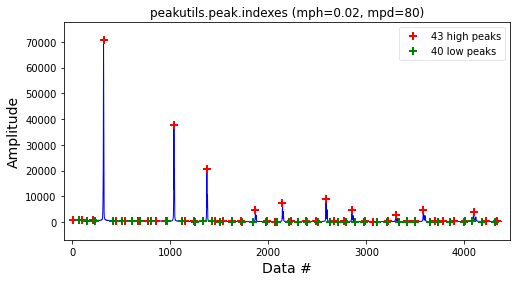

In [35]:
import numpy as np

import peakutils.peak

def plot_peaks_lows_highs(x, highs, lows, algorithm=None, mph=None, mpd=None):
    """Plot results of the peak dectection."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
        return
    _, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(x, 'b', lw=1)
    if highs.size:
        label = 'high peak'
        label = label + 's' if highs.size > 1 else label
        ax.plot(highs, x[highs], '+', mfc=None, mec='r', mew=2, ms=8,
                label='%d %s' % (highs.size, label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    if lows.size:
        label = 'low peak'
        label = label + 's' if lows.size > 1 else label
        ax.plot(lows, x[lows], '+', mfc=None, mec='g', mew=2, ms=8,
                label='%d %s' % (lows.size, label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    ax.set_xlim(-.02*x.size, x.size*1.02-1)
    ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
    yrange = ymax - ymin if ymax > ymin else 1
    ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
    ax.set_xlabel('Data #', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.set_title('%s (mph=%s, mpd=%s)' % (algorithm, mph, mpd))
    plt.show()

threshold = 0.02
min_dist = 80

print('Detect high peaks with minimum height and distance filters.')
highs = peakutils.peak.indexes(
    np.array(cb),
    thres=threshold/max(cb), min_dist=min_dist
)
print('High peaks are: %s' % (highs))

print('Detect low peaks with minimum height and distance filters.')
# Invert the signal.
cbInverted = cb * -1
lows = peakutils.peak.indexes(
    np.array(cbInverted),
    thres=threshold/max(cbInverted), min_dist=min_dist
)
print('Low peaks are: %s' % (lows))

plot_peaks_lows_highs(
    np.array(cb),
    highs,
    lows,
    mph=threshold, mpd=min_dist, algorithm='peakutils.peak.indexes'
)